Nous vous recommandons d'aller voir notre [site sur Github https://github.com/jExbrayat/recognize-handwritten-letters](https://github.com/jExbrayat/recognize-handwritten-letters) si vous avez le temps.

Le site est plus complet que le notebook.

**Instructions**
- télécharger le jeu de données [sur Kaggle](https://www.kaggle.com/datasets/ashishguptajiit/handwritten-az/data)
- le placer dans le `data/original-dataset.csv`
- exécuter le notebook

# 1. Exploratory Data Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
data_folder = "data"
dataset_name = "original-dataset.csv"

img_shape = 28, 28
nb_classes = 26

n_jobs = -1  # pour le parallélisme
letters = [chr(i) for i in range(ord("a"), ord("z") + 1)]

Lisons le jeu de données et examinons sa shape.

In [3]:
df = pd.read_csv(f"{data_folder}/{dataset_name}", header=None)

In [4]:
print(f"Il y a {df.shape[0]} lignes et {df.shape[1]} colonnes")

(3000, 785)

In [5]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [6]:
print(f"{X.shape = }\n{y.shape = }")

X.shape =(3000, 784)
y.shape =(3000,)


/home/ab2/.cache/pypoetry/virtualenvs/m2-bhLFaoX6-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ab2/.cache/pypoetry/virtualenvs/m2-bhLFaoX6-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='0', ylabel='Count'>

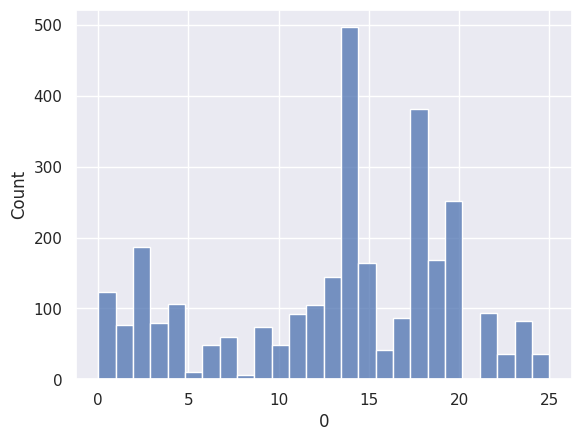

In [7]:
sns.histplot(df[0], bins=nb_classes)
plt.title("Répartition des classes")
plt.xlabel("classe (place dans l'alphabet - 1)")
plt.ylabel("occurrences")

Les classes ne sont pas tout à fait équilibrées, certaines sont quasiment absentes.

Affichons quelques images.

In [8]:
def plot_img(df: pd.DataFrame, index: int) -> None:
    plt.figure(figsize=(1, 1))
    img = np.array(df)[index].reshape(img_shape)
    plt.imshow(img)
    plt.show()

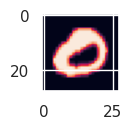

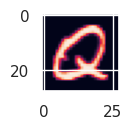

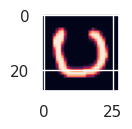

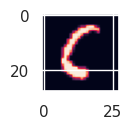

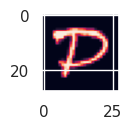

In [9]:
for i in range(5):
    plot_img(X, i)

# 2. Prediction

In [3]:
from sklearn.ensemble import RandomForestClassifier

## Stratégie d'évaluation

On se propose d'utiliser une StratifiedKFold : 
- on utilise la cross-validation (plus fiable que le train/test split)
- on utilise la stratégie KFold (plusieurs passes sur le jeu de données donc une estimation plus fiable)
- on mélange aléatoirement les données ("shuffle") pour éviter un éventuel tri des données initiales (ce qui induirait un fort biais, les données $i$ et $i+1$ pourraient être corrélées si elles étaient triées, et chaque fold pourrait n'être confronté qu'à une seule classe au lieu des 10 dans le pire des cas)
- c'est une méthode très adaptée à un jeu de données avec plusieurs classes : en effet, la version stratifiée permet de respecter la répartition des classes, ce qui est d'autant plus utile que les classes sont déséquilibrées. Ici les classes sont équilibrées donc l'avantage est moindre mais la version stratifiée est théoriquement meilleure.

In [8]:
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split

In [9]:
def strategie_evaluation(seed: int = 0, n_splits: int = 5):
    """Crée notre stratégie d'évaluation"""
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    return kfold

In [10]:
kfold = strategie_evaluation(n_splits=10)

### Métrique

Nous proposons d'utiliser l'accuracy.

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score

### Création du x_train et x_test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [14]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [15]:
# vérifions les shapes
print(f"{X_train.shape = }")
print(f"{y_train.shape = }")
print(f"{X_test.shape = }")
print(f"{y_test.shape = }")

X_train.shape = (2400, 784)
y_train.shape = (2400,)
X_test.shape = (600, 784)
y_test.shape = (600,)


In [17]:
from time import time

#### Evaluation des modèles

In [18]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Affiche l'accuracy et la matrice de confusion du modèle"""
    debut = time()

    model.fit(X_train, y_train)

    fin = time()
    print(f"temps de calcul {round(fin - debut, 2)} s")

    y_pred = model.predict(X_test)

    score = accuracy_score(y_test, y_pred)
    print(f"accuracy = {score}")
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=letters)

    fig, ax = plt.subplots(figsize=(14, 10))
    disp.plot(ax=ax)
    plt.show()

## 1ers modèles (hyper-paramètres par défaut)

Nous allons tester 2 modèles :
- Extra Trees (non vu en cours)
- Random Forest (vu en cours)

Puis nous allons optimiser les hyper-paramètres sur le Random Forest

### Extra Trees (ET)

In [26]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(n_jobs=n_jobs)

temps de calcul 42.86 s
accuracy = 0.9866009031286959


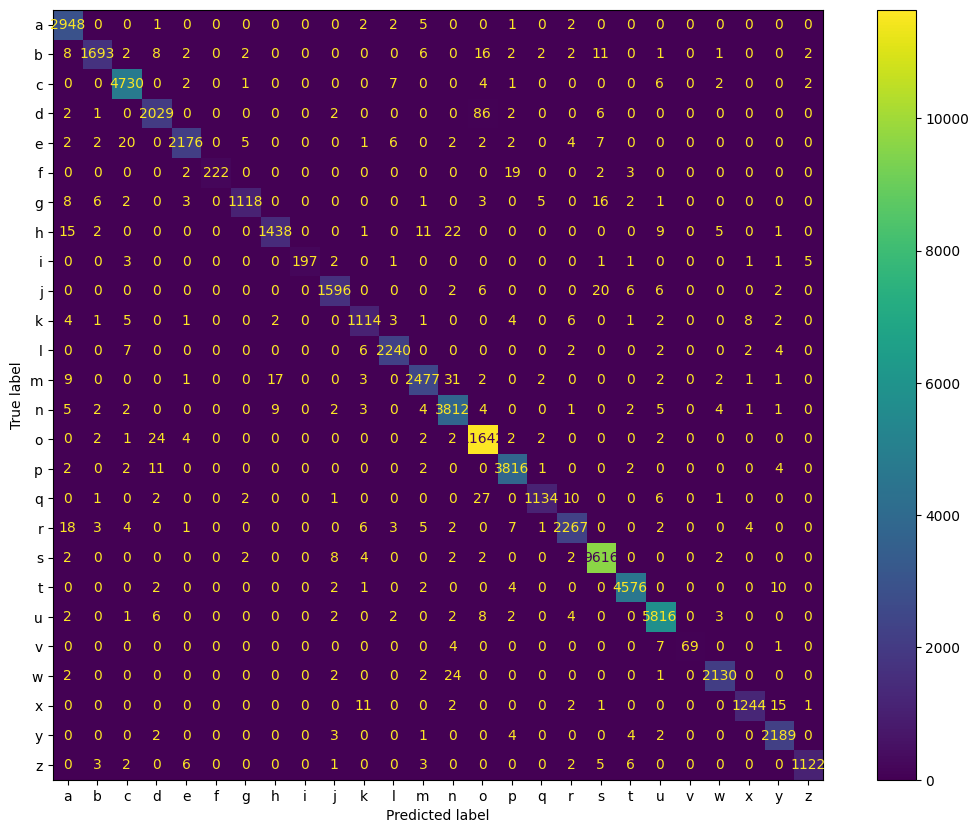

In [27]:
evaluate_model(et, X_train, y_train, X_test, y_test)

### Random Forest

In [28]:
rf_defaut = RandomForestClassifier(random_state=0, n_jobs=n_jobs)

temps de calcul 34.2 s
accuracy = 0.9870175249973121


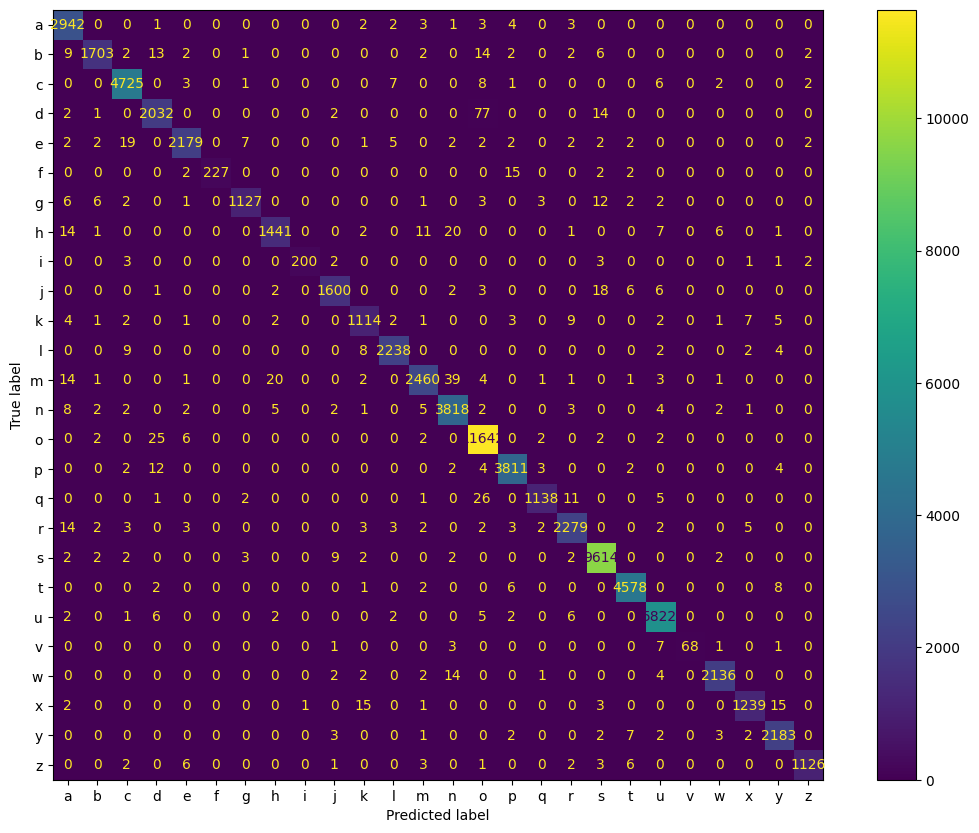

In [29]:
evaluate_model(rf_defaut, X_train, y_train, X_test, y_test)

## Grid search sur Hyper paramètres

Nous effectuons une grid search avec cross-validation Stratified K Fold

In [21]:
from sklearn.model_selection import GridSearchCV

In [22]:
rf_tuning = RandomForestClassifier(random_state=0, n_jobs=n_jobs)

In [23]:
from sklearn.metrics import make_scorer

model_params = {
    "max_depth": [None, 5, 10],
    "n_estimators": [100, 50],
}

clf = GridSearchCV(
    estimator=rf_tuning,
    param_grid=model_params,
    scoring=make_scorer(accuracy_score),
    n_jobs=n_jobs,
    verbose=1,
    cv=kfold,
)

clf.fit(X_train, y_train)  # décommenter pour exécuter (peut durer des dizaines de minutes)
results = pd.DataFrame(clf.cv_results_)  # résultats détaillés de la CV
clf.best_estimator_  # notre meilleur modèle de RandomForest qu'on a obtenu

Fitting 2 folds for each of 6 candidates, totalling 12 fits


/home/ab2/.cache/pypoetry/virtualenvs/m2-bhLFaoX6-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


RandomForestClassifier(n_jobs=-1, random_state=0)

In [24]:
print("Voici les meilleurs paramètres")
print(f"{clf.best_estimator_.max_depth = },\n{clf.best_estimator_.n_estimators = }")

Voici les meilleurs paramètres
clf.best_estimator_.max_depth = None,
clf.best_estimator_.n_estimators = 100


# Bonus : modèles de Deep Learning

Cette partie bonus nous a permis d'expérimenter 2 modèles de réseaux de neurones.

Pour des raisons de simplicité, cette partie n'a pas vocation à être ré-exécutée, mais en cas de besoin nous pouvons vous fournir tous les fichiers né cessaires pour la ré-exécuter. (cf [notre Github https://github.com/jExbrayat/recognize-handwritten-letters](https://github.com/jExbrayat/recognize-handwritten-letters))

## Modèle 1

In [ ]:
import pickle

import numpy as np
from keras.callbacks import EarlyStopping, History
from keras.layers import Dense, Input
from keras.metrics import F1Score
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

dataset = np.loadtxt("data/raw/original-dataset.csv", delimiter=",")

X = dataset[:, 1:]
y = dataset[:, 0]

# Normalize X values between 0 and 1
X = X.astype("float32") / 255

X, X_test, y, y_test = train_test_split(X, y, random_state=42)

# Transform targets into categorical variables
y = to_categorical(y)
y_test = to_categorical(y_test)

model = Sequential()
model.add(Input(shape=(784,)))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(26, activation="softmax"))

model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(),
    metrics=["accuracy", F1Score()],
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=25,
    mode="min",
    restore_best_weights=True,
    start_from_epoch=50,
)

history = History()

model.fit(
    X,
    y,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping, history],
)

# Save model's weights and history
save_path = "data/model_results/classic"
model.save(f"{save_path}/one_hidden_layer_22-12-23.h5")
with open(f"{save_path}/one_hidden_layer_history_22-12-23.pkl", "wb") as history_file:
    pickle.dump(history.history, history_file)

# Get model's loss and accuracy
model_eval = model.evaluate(X, y)

with open(f"{save_path}/one_hidden_layer_evaluate_22-12-23.pkl", "wb") as eval_file:
    pickle.dump(model_eval, eval_file)

## Modèle 2 : réseau de convolution

In [ ]:
import pickle

import numpy as np
from keras.callbacks import EarlyStopping, History
from keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from keras.metrics import F1Score
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

dataset = np.loadtxt("data/raw/original-dataset.csv", delimiter=",")

X = dataset[:, 1:]
y = dataset[:, 0]

# Normalize X values between 0 and 1
X = X.astype("float32") / 255

X, X_test, y, y_test = train_test_split(X, y, random_state=42)

# Save test dataset to test model without reloading whole dataset after training
test_dataset = np.concatenate((y_test.reshape(-1, 1), X_test), axis=1)
np.savetxt("data/processed/test-dataset.csv", test_dataset, delimiter=",")

# Transform targets into categorical variables
y = to_categorical(y)
y_test = to_categorical(y_test)

model = Sequential()
model.add(Input(shape=(784,)))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(26, activation="softmax"))

model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(),
    metrics=["accuracy", F1Score()],
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=50,
    mode="min",
    restore_best_weights=True,
    start_from_epoch=150,
)

history = History()

model.fit(
    X,
    y,
    epochs=750,
    validation_split=0.2,
    callbacks=[early_stopping, history],
)

# Get model's loss and accuracy
model_eval = model.evaluate(X, y)

# Save model's results
save_path = "data/model_weights/cnn"

model.save(f"{save_path}/cnn_experiment_21-12-23.h5")

with open(f"{save_path}/cnn_experiment_history_21-12-23.pkl", "wb") as history_file:
    pickle.dump(history.history, history_file)

with open(f"{save_path}/cnn_experiment_evaluate.pkl", "wb") as eval_file:
    pickle.dump(model_eval, eval_file)

## Affichage des résultats ci-dessous

In [0]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [ ]:
def plot_training_curve(
        training_loss: list,
        validation_loss: list,
        plot_from_n_epoch: int,
        validation_accuracy: list = None,
        save_path: str = None,
) -> None:
    """Plot training curves of a keras model
    (train loss, val loss, val accuracy if classification model)

    Args:
        training_loss (list): training loss
        gathered from history callback

        validation_loss (list): validation loss
        gathered from history callback

        validation_accuracy (list): validation accuracy gathered
        from history callback

        plot_from_n_epoch (int): epoch from which to plot when there are too many
        save_path (str): path to save plot in .png format
    """

    num_epochs_to_display = len(training_loss) - plot_from_n_epoch
    step_x_ticks = (
        int(num_epochs_to_display / 10) if int(num_epochs_to_display / 10) >= 1 else 1
    )

    plt.plot(training_loss[plot_from_n_epoch:], label="training loss")
    plt.plot(validation_loss[plot_from_n_epoch:], label="validation loss")

    if validation_accuracy is not None:
        plt.plot(validation_accuracy[plot_from_n_epoch:], label="validation accuracy")

    plt.legend()
    plt.title("training curve")

    plt.xticks(
        np.arange(0, num_epochs_to_display, step=step_x_ticks),
        np.arange(
            plot_from_n_epoch + 1,
            plot_from_n_epoch + num_epochs_to_display + 1,
            step=step_x_ticks,
        ),
    )

    if save_path is not None:
        plt.savefig(save_path)

    plt.show()

## Lire les résultats du modèle

Nous allons lire et afficher les résultats du modèle de CNN uniquement.

In [0]:
model_results_folder = "data/model_results/cnn"

In [0]:
with open(
    f"{model_results_folder}/cnn_experiment_history_21-12-23.pkl", "rb"
) as pickle_file:
    model_history = pickle.load(pickle_file)

In [0]:
with open(
    f"{model_results_folder}/cnn_experiment_evaluate_21-12-23.pkl", "rb"
) as pickle_file:
    model_evaluate = pickle.load(pickle_file)

## Affichage des courbes d'entraînement

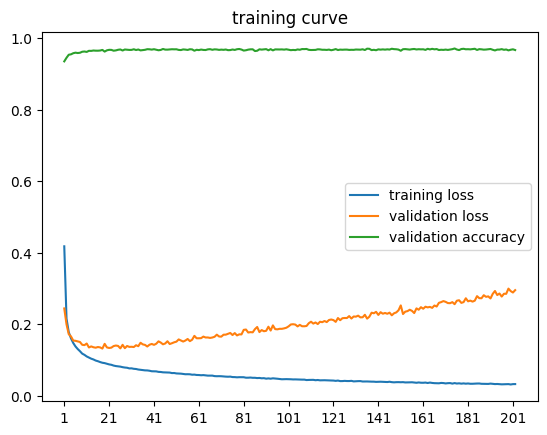

In [0]:
plot_training_curve(
    training_loss=model_history["loss"],
    validation_loss=model_history["val_loss"],
    validation_accuracy=model_history["val_accuracy"],
    plot_from_n_epoch=0,
    save_path=f"{model_results_folder}/training_curve.png",
)

In [0]:
print(f"categorical_crossentropy (loss) = {model_evaluate[0]}")
print(f"accuracy = {model_evaluate[1]}")

categorical_crossentropy (loss) = 0.0686769038438797
accuracy = 0.9871518015861511


## Matrice de confusion
### Prédiction jeu de test

In [0]:
model = load_model(f"{model_results_folder}/cnn_experiment_21-12-23.h5")

In [0]:
full_test_dataset_path = "data/raw/test-dataset.csv"
sample_test_dataset_path = "data/raw/sample-test-dataset.csv"

In [0]:
# Open full test dataset if it exists locally, open sample test dataset otherwise

if os.path.exists(full_test_dataset_path):
    test_dataset = np.loadtxt(full_test_dataset_path, delimiter=",")
else:
    test_dataset = np.loadtxt(sample_test_dataset_path, delimiter=",")

In [0]:
y = test_dataset[:, 0]
X = test_dataset[:, 1:]

In [0]:
y_categorical = to_categorical(y)

In [0]:
y_pred = model.predict(X)

2907/2907 [==============================] - 17s 5ms/step


### Conversion y_pred formal original

In [0]:
y_pred_convert = list(map(np.argmax, y_pred))

In [0]:
letters = [chr(i) for i in range(ord("a"), ord("z") + 1)]

### Affichage matrice de confusion

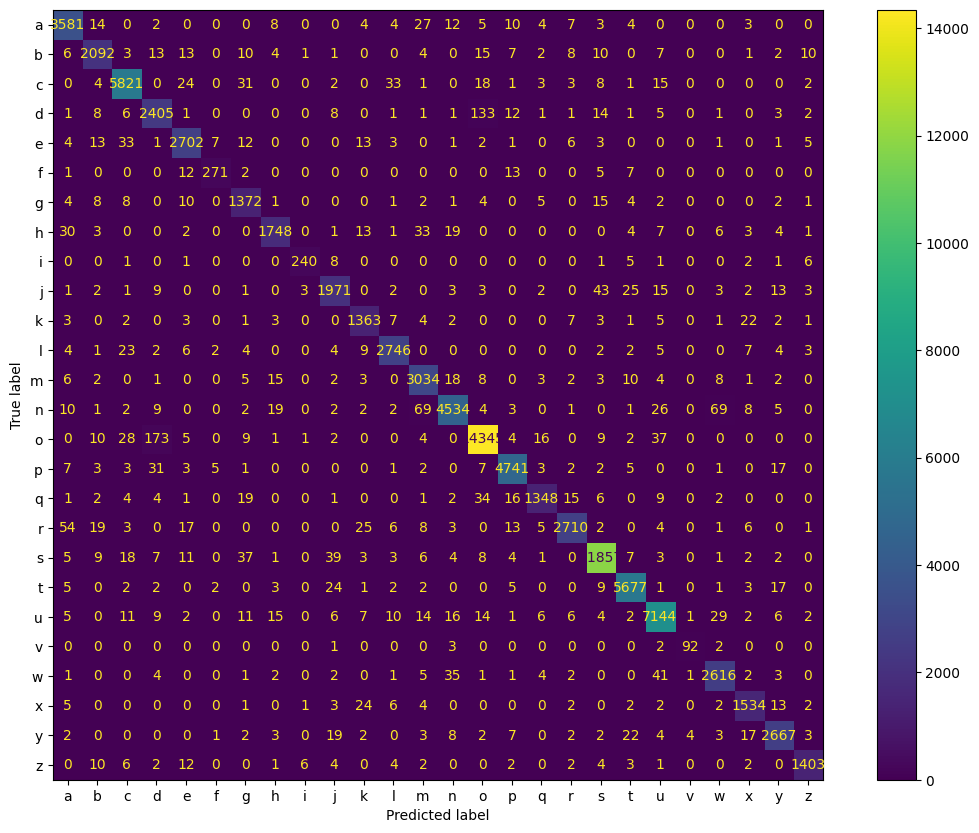

In [0]:
cm = confusion_matrix(y_true=y, y_pred=y_pred_convert)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=letters)

fig, ax = plt.subplots(figsize=(14, 10))
disp.plot(ax=ax)
plt.savefig(f"{model_results_folder}/confusion_matrix.png")
plt.show()

# Scores calculated on test dataset

In [42]:
from sklearn.metrics import f1_score, recall_score, precision_score

f1 = f1_score(y, y_pred_convert, average="weighted")
accuracy = accuracy_score(y, y_pred_convert)
precision = precision_score(y, y_pred_convert, average="weighted")
recall = recall_score(y, y_pred_convert, average="weighted")

In [43]:
print(f"{f1 =}")
print(f"{accuracy =}")
print(f"{precision =}")
print(f"{recall =}")

f1 =0.9678085033395537
accuracy =0.9677884098484034
precision =0.9679548259525955
recall =0.9677884098484034


Le modèle obtient des résultats similaires au meilleur Random Forest, mais légèrement inférieurs, de 2%.